# OCR Model Benchmarking: CRNN vs ResNet18 vs ViT-Tiny

### Why **CRNN → ResNet-18 → ViT-Tiny** were chosen

| Family                     | Concrete model we use                               | Why it belongs in the benchmark                                                                                                                                                                                                                                                                                                         | Key references in the labs                                                                                                              |
| -------------------------- | --------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------- |
| **Recurrent-CNN baseline** | **CRNN** (small custom CNN + 2 × Bi-LSTM)           | *Historical anchor.*<br>• Purely “from-scratch”, no ImageNet weights → shows what the dataset itself can teach the network.<br>• Extremely light (<1 M params) and easy to train/interpret.          | *lab\_mlp\_cnn* → basic CNN building blocks.<br>*lab\_rnn* → Bi-LSTM sequencing.
| **Transfer-learning CNN**  | **ResNet-18** (pre-trained, frozen-then-fine-tuned) | *Strong classical baseline.*<br>• Convolutional features are well matched to local stroke patterns in text.<br>• ImageNet pre-training means we need < fewer labelled lines to reach low CER.<br>• Still modest size (≈11 M params), fast on Colab GPUs.                                                                                | *lab\_transfer\_learning* shows how to freeze, then unfreeze.<br>*lab\_contrastive* motivates using powerful encoders with small heads. |
| **Vision Transformer**     | **ViT-Tiny Patch16** (pre-trained)                  | *Modern research variant.*<br>• Self-attention can capture long-range relations → good for long text strings and wide aspect ratios.<br>• Patch-wise design simplifies to a 1-D sequence → meshes naturally with CTC after minimal reshaping.<br>• ViT-Tiny (192-dim, 12 layers) keeps GPU memory within Colab limits, unlike ViT-Base. | *lab\_diffusion* & *NLP Transformer labs* demonstrate positional embedding tricks we re-used (interpolating PE).                        |


_We retained the CRNN baseline for continuity and did two deliberate upgrades:_

*   **ResNet-18** to leverage transfer-learning from natural-image CNNs while keeping a lightweight model.
    
*   **ViT-Tiny** to test whether modern transformer backbones improve OCR on wide text lines; we added positional-embedding interpolation so it runs at 32×160 inputs.
    

These three checkpoints give us a clear picture of **classical vs. transfer-learning vs. transformer** performance on the exact same dataset and training script.

## 1. Installing Dependencies

**Workflow**

1. Run **Install & login** (installs `timm`, `wandb`& co.).  
2. Run **Config + W&B** to set hyper-params and start a W&B run.  
3. Execute cells top-to-bottom; checkpoints are saved as `best_<arch>.pth`.  
4. Switch `arch`, rerun from Config downward to benchmark another backbone.

Labs referenced: *Transfer Learning*, *Contrastive*, *Diffusion*, *MLP-CNN*.  


In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
# Imports
import os, random, time, shutil, glob, math, re, unicodedata
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.io as io
from torchvision.transforms.v2 import Compose, RandomRotation, RandomAffine, Resize, Grayscale, ToDtype
import timm
import wandb
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [39]:
# --- Architecture Selection and Global Configuration ---

arch = "vit_tiny"  # Choose from: 'crnn', 'resnet18', 'vit_tiny'

# Architecture configurations
config_crnn = dict(
    img_h=32,
    img_w=192,         # Extended width for longer text sequences (>12-14 characters)
    batch_size=64,     # Larger batches possible due to lightweight architecture
    epochs=25,         # Reduced epochs for faster convergence on 22k dataset
    max_lr=1e-3,       # Higher learning rate works well with CRNN + Adam
    nh=256,            # Hidden units for BiLSTM layers
    device="cuda",     # Use GPU if available
    beam_width=10,     # For CTC decoding
    top_k=5,          # For accuracy@k metrics
    seed=42,          # For reproducibility
    early_stopping_patience=3  # Stop if no improvement for 3 epochs
)

config_resnet18 = dict(
    img_h=32,          # Standard height for OCR
    img_w=256,         # Wider input for better context
    batch_size=24,     # Reduced batch size for larger model
    epochs=30,         # More epochs for transfer learning phases
    max_lr=5e-4,       # Conservative learning rate for fine-tuning
    nh=384,            # Increased RNN capacity for richer features
    device="cuda",
    beam_width=5,
    top_k=3,
    seed=42,
    early_stopping_patience=3,
    warmup_epochs=2,    # Gradual warmup for transfer learning
    unfreeze_epoch=5    # When to unfreeze backbone
)

config_vit_tiny = dict(
    img_h=64,          # ViT standard input height
    img_w=256,         # Extended width for text sequences
    batch_size=16,     # Reduced for transformer memory requirements
    epochs=40,         # Longer training for transformer convergence
    max_lr=2e-4,       # Conservative rate for transformer
    nh=384,            # Standard ViT-tiny dimension
    device="cuda",
    beam_width=5,
    top_k=3,
    seed=42,
    early_stopping_patience=4,  # More patience for transformer
    warmup_epochs=3,           # Longer warmup for stability
    unfreeze_epoch=8          # Later unfreezing for better feature learning
)

def get_config(arch: str) -> dict:
    """
    Get the configuration for a specific architecture.

    Args:
        arch: One of 'crnn', 'resnet18', or 'vit_tiny'

    Returns:
        Dictionary with optimized hyperparameters

    Raises:
        ValueError: If architecture is not supported
    """
    configs = {
        "crnn": config_crnn,
        "resnet18": config_resnet18,
        "vit_tiny": config_vit_tiny
    }
    if arch not in configs:
        raise ValueError(f"Unsupported architecture: {arch}. Choose from {list(configs.keys())}")
    config = configs[arch].copy()
    config["arch"] = arch
    return config

# Initialize with default architecture
config = get_config(arch)
print(f"🔧 Configuration loaded for: {arch}")

# Set up reproducibility
def set_global_seed(seed=42):
    """Sets random seeds for reproducibility across runs."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_global_seed(config["seed"])

🔧 Configuration loaded for: vit_tiny


In [28]:
# --- Change architecture and reinitialize pipeline ---
def switch_architecture(new_arch: str):
    """
    Changes the architecture and reinitializes the entire pipeline with optimal configuration.

    Args:
        new_arch: 'crnn', 'resnet18' or 'vit_tiny'
    """
    global config
    config = get_config(new_arch)  # Obtiene la configuración optimizada
    print(f"Switched architecture to: {new_arch}")
    print(f"New config: batch_size={config['batch_size']}, img_size={config['img_h']}×{config['img_w']}, lr={config['max_lr']}")

    set_global_seed(config["seed"])

    # Recreate datasets and dataloaders (if needed)
    global train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader
    train_dataset = TextRecognitionDataset(TRAIN_LABELS, is_train=True)
    val_dataset   = TextRecognitionDataset(VAL_LABELS,  is_train=False, char_list=train_dataset.get_vocab())
    test_dataset  = TextRecognitionDataset(TEST_LABELS, is_train=False, char_list=train_dataset.get_vocab())
    train_loader = DataLoader(train_dataset, shuffle=True,  **common_loader_kwargs)
    val_loader   = DataLoader(val_dataset,   shuffle=False, **common_loader_kwargs)
    test_loader  = DataLoader(test_dataset,  shuffle=False, **common_loader_kwargs)

    # Recreate model, optimizer, scheduler
    global model, optimizer, scheduler, scaler, unfreeze_epoch, device
    device = torch.device(config["device"] if torch.cuda.is_available() else "cpu")
    model = build_model(new_arch).to(device)

    if new_arch == "crnn":
        optimizer = torch.optim.AdamW(model.parameters(), lr=config["max_lr"])
        unfreeze_epoch = -1
    else:
        backbone_lr = 1e-4
        optimizer = torch.optim.AdamW([
            {"params": model.backbone.parameters(), "lr": backbone_lr},
            {"params": list(model.rnn1.parameters()) +
                      list(model.rnn2.parameters()) +
                      list(model.fc.parameters()),
             "lr": config["max_lr"]},
        ])
        for p in model.backbone.parameters():
            p.requires_grad = False
        unfreeze_epoch = 2

    total_steps = config["epochs"] * len(train_loader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=config["max_lr"],
        total_steps=total_steps,
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    # Re-initialize wandb run
    wandb.finish()
    wandb.login()
    global run
    run = wandb.init(
        project="OCR",
        group=new_arch,
        name=f'{new_arch}_{wandb.util.generate_id()}',
        config=config,
        resume="allow",
    )
    print("✨ Pipeline reinitialized. Ready to train!")

## 2. Helper Functions

### About Utility Functions
This section defines essential helper functions used throughout the notebook. The implementation includes text normalization utilities, decoding functions, metric calculations (CER, word accuracy), and visualization tools.

In [29]:
# --- Normalization, decoding, metrics, and visualization helpers ---
# Text normalization for OCR outputs
def normalize_text(s: str) -> str:
    import unicodedata, re
    s = unicodedata.normalize("NFKC", s)
    s = re.sub(r"\s+", " ", s)
    return s.strip().lower()

# Character Error Rate (CER)
def character_error_rate(preds, gts):
    import editdistance
    assert len(preds) == len(gts)
    edits = sum(editdistance.eval(normalize_text(p), normalize_text(g)) for p, g in zip(preds, gts))
    total = sum(len(normalize_text(g)) for g in gts)
    return edits / max(1, total)

# Word Accuracy at k
def word_accuracy_at_k(preds, gts, k=0):
    import editdistance
    assert len(preds) == len(gts)
    hits = sum(editdistance.eval(normalize_text(p), normalize_text(g)) <= k for p, g in zip(preds, gts))
    return hits / len(gts)

# CTC Greedy Decoder
def ctc_greedy_decoder(logits_TBC, vocab, blank_idx=None):
    from itertools import groupby
    if blank_idx is None: blank_idx = len(vocab)
    logits_BTC = logits_TBC.permute(1, 0, 2).contiguous()
    max_idx = logits_BTC.cpu().argmax(2).numpy()
    decoded = []
    for seq in max_idx:
        merged = [k for k, _ in groupby(seq)]
        chars = [vocab[i] for i in merged if i != blank_idx and i < len(vocab)]
        decoded.append("".join(chars))
    return decoded

# Decode label indices to string
def decode_label(encoded, vocab, blank_idx=None):
    if blank_idx is None: blank_idx = len(vocab)
    return "".join(vocab[i] for i in encoded if i != blank_idx and i < len(vocab))

# Improved visualization function
def visualize_predictions(model, dataset, vocab, blank_idx, n=6, batch=None):
    """
    Visualizes a batch of predictions vs ground truths.
    If batch is None, samples a random batch from the dataset.
    Prints predictions and ground truths under each image and in the console.
    """
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    model.eval()
    if batch is None:
        loader = DataLoader(dataset, batch_size=n, shuffle=True, collate_fn=collate_fn)
        imgs, labels, lens = next(iter(loader))
    else:
        imgs, labels, lens = batch
    imgs_gpu = imgs.to(device)
    with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):
        preds_logits = model(imgs_gpu).log_softmax(2)
    pred_texts = ctc_greedy_decoder(preds_logits, vocab, blank_idx)
    true_texts = [decode_label(labels[i, :lens[i]].cpu().tolist(), vocab, blank_idx) for i in range(len(labels))]
    plt.figure(figsize=(16,3))
    for i, (img, p_txt, t_txt) in enumerate(zip(imgs, pred_texts, true_texts)):
        plt.subplot(1, n, i+1)
        if img.shape[0] == 3:
            plt.imshow(img.permute(1,2,0))
        else:
            plt.imshow(img.squeeze(), cmap="gray")
        plt.axis("off")
        plt.title(f"GT: {t_txt}\nPR: {p_txt}", fontsize=9)
    plt.tight_layout(); plt.show()
    print("\nPredictions vs Ground Truth:")
    for i, (p, g) in enumerate(zip(pred_texts, true_texts)):
        print(f"[{i}] PRED: '{p}' | GT: '{g}'")

In [30]:
# --- Validation metrics counter ---
class ValCounter:
    """Keeps track of validation metrics across batches."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.total_chars = 0
        self.total_edits = 0
        self.total_words = 0
        self.hits_at = {k: 0 for k in range(3)}  # Word accuracy at 0,1,2 edits

    def _clean(self, text: str) -> str:
        """Normalize text for consistent comparison."""
        return text.strip().lower()

    def update(self, preds: list[str], gts: list[str]):
        """Update metrics with a new batch of predictions."""
        import editdistance
        assert len(preds) == len(gts), "Predictions and ground truths must match"

        for pred, gt in zip(preds, gts):
            pred, gt = self._clean(pred), self._clean(gt)
            # Character error rate
            edits = editdistance.eval(pred, gt)
            self.total_edits += edits
            self.total_chars += len(gt)
            # Word accuracy at different edit distances
            self.total_words += 1
            for k in self.hits_at:
                if edits <= k:
                    self.hits_at[k] += 1

    def compute(self) -> dict[str, float]:
        """Compute final metrics."""
        cer = self.total_edits / max(1, self.total_chars)
        metrics = {"CER": cer}
        # Add word accuracy metrics
        for k in self.hits_at:
            metrics[f"Word Accuracy @ {k}"] = self.hits_at[k] / max(1, self.total_words)
        return metrics

In [31]:
# --- Utility to resize ViT position-embeddings ---
def resize_pos_embed(pe: torch.Tensor, h_tokens: int, w_tokens: int) -> torch.Tensor:
    """
    Expand/shrink the grid part of ViT positional-embedding to h_tokens × w_tokens.
    pe shape: [1, 1+N, dim] (includes CLS token)
    """
    cls_tok, grid_tok = pe[:, :1], pe[:, 1:]
    old = int(grid_tok.shape[1] ** 0.5)
    dim = grid_tok.shape[-1]
    grid_tok = grid_tok.reshape(1, old, old, dim).permute(0, 3, 1, 2)
    grid_tok = torch.nn.functional.interpolate(
        grid_tok, size=(h_tokens, w_tokens), mode="bicubic", align_corners=False
    )
    grid_tok = grid_tok.permute(0, 2, 3, 1).reshape(1, h_tokens * w_tokens, dim)
    return torch.cat((cls_tok, grid_tok), dim=1)

## 3. Data Pipeline Setup

### Data Pipeline Overview

This section handles the complete data preparation pipeline for OCR training:

1. **Data Organization**
   - Mounts Google Drive for dataset access
   - Verifies dataset splits (train/val/test)
   - Creates local cache for faster loading

2. **Dataset Implementation**
   - Custom `TextRecognitionDataset` class
   - Efficient image loading with torchvision.io
   - On-the-fly augmentations for training
   - Character vocabulary management

3. **Data Loading Configuration**
   - Multi-worker data loading with PyTorch
   - Pinned memory for faster GPU transfers
   - Collate function for variable-length sequences
   - Proper seeding for reproducibility

4. **Image Transformations**
   - Resizing to architecture-specific dimensions
   - Data augmentation (rotation, translation)
   - Proper grayscale to RGB conversion
   - Tensor type and range normalization

In [32]:
# --- Dataset and DataLoader Setup with Error Handling ---

from google.colab import drive
drive.mount('/content/drive')

# Setup paths and verify data
BASE_DIR = "/content/drive/MyDrive/DocAnonymizer/subset_22000"
TRAIN_LABELS = f"{BASE_DIR}/labels_train_clean.txt"
VAL_LABELS   = f"{BASE_DIR}/labels_val_clean.txt"
TEST_LABELS  = f"{BASE_DIR}/labels_test_clean.txt"

# Verify dataset existence
missing_files = []
for p in (TRAIN_LABELS, VAL_LABELS, TEST_LABELS):
    if not os.path.exists(p):
        missing_files.append(p)
if missing_files:
    raise FileNotFoundError(f"Missing dataset files: {missing_files}")
print("✅ Dataset splits verified")

# Create local cache with error handling
LOCAL_DATA = "/content/ocr_local"
try:
    if not os.path.exists(LOCAL_DATA):
        t0 = time.time()
        shutil.copytree(BASE_DIR, LOCAL_DATA, dirs_exist_ok=True)
        print(f"✅ Dataset cached to {LOCAL_DATA} in {time.time()-t0:.1f}s")
    BASE_DIR = LOCAL_DATA
    TRAIN_LABELS = f"{BASE_DIR}/labels_train_clean.txt"
    VAL_LABELS   = f"{BASE_DIR}/labels_val_clean.txt"
    TEST_LABELS  = f"{BASE_DIR}/labels_test_clean.txt"
except Exception as e:
    print(f"⚠️ Warning: Could not create local cache: {str(e)}")
    print("Continuing with original paths...")

class TextRecognitionDataset(Dataset):
    """
    Dataset for OCR training with efficient image loading and augmentation.

    Args:
        label_file (str): Path to label file with format: img_path<TAB>label
        is_train (bool): Whether this is training set (enables augmentation)
        char_list (List[str], optional): Character vocabulary. If None, built from data
    """
    def __init__(self, label_file, is_train: bool, char_list=None):
        # Clean and validate data
        df = (pd.read_csv(label_file, sep="\t", names=["img_path", "label"])
              .dropna()
              .query("label.str.len() > 0", engine="python"))
        self.samples = df.reset_index(drop=True)
        self.base_dir = os.path.dirname(label_file)

        # Setup vocabulary
        self.char_list = (sorted(set("".join(df["label"]))) if char_list is None else char_list)
        self.blank_idx = len(self.char_list)

        # Configure augmentations
        aug = []
        if is_train:
            aug = [
                RandomRotation(2),
                RandomAffine(2, translate=(0.02,0.02))
            ]

        # Build transform pipeline
        self.tf = Compose([
            *aug,
            Resize((config["img_h"], config["img_w"]), antialias=True),
            Grayscale(num_output_channels=3),
            ToDtype(torch.float32, scale=True)
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """Get an image-label pair with proper error handling."""
        try:
            row = self.samples.iloc[idx]
            img_path = os.path.join(self.base_dir, row["img_path"])

            # Robust image loading
            try:
                img = io.read_image(img_path, mode=io.ImageReadMode.GRAY)
            except Exception as e:
                print(f"Error loading image {img_path}: {str(e)}")
                # Return a blank image as fallback
                img = torch.zeros((1, config["img_h"], config["img_w"]), dtype=torch.uint8)

            # Apply transforms
            img = self.tf(img)

            # Convert text to indices
            label_idx = torch.tensor([
                self.char_list.index(c) for c in row["label"]
            ], dtype=torch.long)

            return img, label_idx

        except Exception as e:
            print(f"Error processing sample {idx}: {str(e)}")
            # Return a valid but empty sample as fallback
            return (torch.zeros((3, config["img_h"], config["img_w"])),
                   torch.zeros(1, dtype=torch.long))

    def get_vocab(self): return self.char_list
    def get_blank_idx(self): return self.blank_idx

def collate_fn(batch):
    """
    Custom collation for variable length sequences.
    Handles potential None values from failed samples.
    """
    # Filter out any None values from failed samples
    batch = [(img, lbl) for img, lbl in batch if img is not None and lbl is not None]
    if not batch:
        raise RuntimeError("Entire batch was invalid")

    imgs, labels = zip(*batch)
    imgs = torch.stack(imgs)
    lens = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = pad_sequence(labels, batch_first=True)
    return imgs, labels, lens

# Optimize number of workers based on system
NUM_WORKERS = min(8, os.cpu_count() or 1)  # Fallback to 1 if cpu_count fails

def get_loader_kwargs() -> dict:
    """Get optimized DataLoader settings."""
    return dict(
        batch_size=config["batch_size"],
        num_workers=NUM_WORKERS,
        pin_memory=torch.cuda.is_available(),
        prefetch_factor=2,
        persistent_workers=True,
        collate_fn=collate_fn,
        worker_init_fn=lambda worker_id: set_global_seed(config["seed"] + worker_id)
    )

# Create datasets and loaders with proper error handling
try:
    train_dataset = TextRecognitionDataset(TRAIN_LABELS, is_train=True)
    val_dataset   = TextRecognitionDataset(VAL_LABELS,  is_train=False, char_list=train_dataset.get_vocab())
    test_dataset  = TextRecognitionDataset(TEST_LABELS, is_train=False, char_list=train_dataset.get_vocab())

    common_loader_kwargs = get_loader_kwargs()
    train_loader = DataLoader(train_dataset, shuffle=True,  **common_loader_kwargs)
    val_loader   = DataLoader(val_dataset,   shuffle=False, **common_loader_kwargs)
    test_loader  = DataLoader(test_dataset,  shuffle=False, **common_loader_kwargs)

    print(f"📊 Dataset sizes: Train={len(train_dataset):,} | Val={len(val_dataset):,} | Test={len(test_dataset):,}")
    print(f"📝 Vocabulary size: {len(train_dataset.get_vocab())}")

except Exception as e:
    raise RuntimeError(f"Failed to initialize datasets: {str(e)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset splits verified
📊 Dataset sizes: Train=17,598 | Val=2,200 | Test=2,199
📝 Vocabulary size: 62


## 4. Model Architecture

### About Model Architecture Design
This section contains the implementation of neural network architectures for OCR. The design includes a classic CRNN (CNN + BiLSTM), a flexible VisionBackbone (ResNet18 or ViT-Tiny), and the OCRNet wrapper.

In [33]:
# --- Model definitions: CRNN, VisionBackbone, OCRNet ---
# CRNN: Classic CNN + BiLSTM for OCR
class CRNN(nn.Module):
    def __init__(self, img_h=32, nc=3, nclass=100, nh=256):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(nc, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,1,1), nn.ReLU(), nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,1,1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256,256,3,1,1), nn.ReLU(), nn.MaxPool2d((2,1)),
            nn.Conv2d(256,512,3,1,1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.MaxPool2d((2,1)),
            nn.Conv2d(512,512,2), nn.ReLU()
        )
        self.rnn1 = nn.LSTM(512, nh, bidirectional=True)
        self.rnn2 = nn.LSTM(nh*2, nh, bidirectional=True)
        self.fc   = nn.Linear(nh*2, nclass)
    def forward(self, x):
        f = self.cnn(x)
        f = f.squeeze(2).permute(2,0,1)
        f, _ = self.rnn1(f)
        f, _ = self.rnn2(f)
        return self.fc(f)  # (T,B,C)

# VisionBackbone: ResNet18 or ViT-Tiny backbone for OCRNet
class VisionBackbone(nn.Module):
    def __init__(self, name="resnet18"):
        super().__init__()
        self.name = name
        if name == "resnet18":
            m = timm.create_model("resnet18", pretrained=True, num_classes=0)
            # Modify structure to preserve more spatial information
            layers = list(m.children())[:-2]
            # Reduce stride in final layers
            layers[-1][0].conv1.stride = (1,1)
            layers[-1][0].downsample[0].stride = (1,1)
            self.core = nn.Sequential(*layers)
            self.adapt = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True)
            )
            self.out_ch = 512
            self.patch = None
        elif name == "vit_tiny":
            m = timm.create_model("vit_tiny_patch16_224", pretrained=True, num_classes=0, global_pool="")
            m.patch_embed.strict_img_size = False
            self.core   = m
            self.patch  = 16
            self.out_ch = m.embed_dim
            _orig_forward = m.forward
            def _core_forward(x):
                B, _, H, W = x.shape
                gh, gw = H // self.patch, W // self.patch
                need = gh * gw + 1
                if m.pos_embed.shape[1] != need:
                    m.pos_embed = torch.nn.Parameter(resize_pos_embed(m.pos_embed, gh, gw))
                return _orig_forward(x)
            self.core.forward = _core_forward
        else:
            raise ValueError(f"Backbone {name} not supported")
    def _collapse_cnn(self, f):
        if self.name == "resnet18":
            # Preserve horizontal spatial information
            f = self.adapt(f)
            f = f.mean(dim=2)  # Vertical average only
            return f.permute(2,0,1)  # T,B,C
        else:
            f = f.mean(dim=2)
            return f.permute(2,0,1)
    def forward(self, x):
        f = self.core(x)
        if self.name == "resnet18":
            return self._collapse_cnn(f)
        elif self.name == "vit_tiny":
            f = f[:,1:,:]
            B, N, D = f.shape
            gh = x.shape[2] // self.patch
            f = f.view(B, gh, -1, D).permute(0,3,1,2)
            return self._collapse_cnn(f)

# OCRNet: Backbone + BiLSTM + FC head
class OCRNet(nn.Module):
    def __init__(self, vocab_size, backbone="resnet18", nh=256):
        super().__init__()
        self.backbone = VisionBackbone(backbone)
        self.rnn1 = nn.LSTM(self.backbone.out_ch, nh, bidirectional=True)
        self.rnn2 = nn.LSTM(nh*2, nh, bidirectional=True)
        self.fc   = nn.Linear(nh*2, vocab_size)
    def forward(self, x):
        x = self.backbone(x)
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        return self.fc(x)

## 5. Model Setup

### About Model Initialization Process
This section handles model instantiation, optimizer configuration, and learning rate scheduler setup according to the selected architecture configuration. The implementation includes loss function (CTC Loss) setup and AMP scaler configuration for mixed-precision training, ensuring efficient and stable model training across different hardware configurations.

In [34]:
# --- Model, optimizer, and scheduler setup ---
# Build model based on config
def build_model(arch: str):
    if arch == "crnn":
        return CRNN(img_h=config["img_h"], nc=3, nclass=len(train_dataset.get_vocab())+1, nh=config["nh"])
    model = OCRNet(vocab_size=len(train_dataset.get_vocab())+1, backbone=arch, nh=config["nh"])

    # Progressive freezing strategy for ResNet18
    if arch == "resnet18":
        # Initially freeze everything except the last layers
        for name, param in model.backbone.named_parameters():
            if "layer4" not in name and "adapt" not in name:
                param.requires_grad = False

    return model

device = torch.device(config["device"] if torch.cuda.is_available() else "cpu")
model = build_model(config["arch"]).to(device)

# Optimizer and scheduler
if config["arch"] == "crnn":
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["max_lr"])
    unfreeze_epoch = -1
else:
    if config["arch"] == "resnet18":
        # Groups with different learning rates
        param_groups = [
            {"params": [], "lr": config["max_lr"] * 0.1},  # frozen backbone
            {"params": [], "lr": config["max_lr"] * 0.3},  # layer4 + adapt
            {"params": [], "lr": config["max_lr"]}         # RNN + FC
        ]

        for name, param in model.named_parameters():
            if "backbone" in name:
                if "layer4" in name or "adapt" in name:
                    param_groups[1]["params"].append(param)
                else:
                    param_groups[0]["params"].append(param)
            else:
                param_groups[2]["params"].append(param)

        optimizer = torch.optim.AdamW(param_groups)
        unfreeze_epoch = 5  # More epochs before unfreezing
    else:
        # Original configuration for ViT
        backbone_lr = 1e-4
        optimizer = torch.optim.AdamW([
            {"params": model.backbone.parameters(), "lr": backbone_lr},
            {"params": list(model.rnn1.parameters()) + list(model.rnn2.parameters()) + list(model.fc.parameters()), "lr": config["max_lr"]},
        ])
        unfreeze_epoch = 2

criterion = nn.CTCLoss(blank=train_dataset.get_blank_idx(), zero_infinity=True)

total_steps = config["epochs"] * len(train_loader)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config["max_lr"],
    total_steps=total_steps,
    )

use_amp  = (device.type == "cuda")
scaler   = torch.cuda.amp.GradScaler(enabled=use_amp)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

/tmp/ipython-input-34-1548806451.py:63: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler   = torch.cuda.amp.GradScaler(enabled=use_amp)


In [35]:
# --- Weights & Biases (wandb) initialization ---
import wandb
wandb.login()  # You may need to provide your API key the first time
run = wandb.init(
    project="OCR",  # Change to your project name
    group=config["arch"],
    name=f'{config["arch"]}_{wandb.util.generate_id()}',
    config=config,
    resume="allow",
)

## 6. Training Loop

### About Training Process Implementation
This section implements the main training and validation loop. The training function manages forward/backward passes, optimizer steps, and learning rate scheduling, while the validation function evaluates model performance on the validation set using multiple metrics. The implementation includes checkpoint management to preserve the best-performing model state.

In [36]:
# --- Training and validation loop with improved error handling and monitoring ---

class CheckpointManager:
    """Manages model checkpoints and early stopping."""
    def __init__(self, patience=3):
        self.best_loss = float('inf')
        self.best_epoch = 0
        self.patience = patience
        self.no_improve = 0

    def should_save(self, val_loss: float, epoch: int) -> bool:
        """Check if current model should be saved."""
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.no_improve = 0
            return True
        self.no_improve += 1
        return False

    def should_stop(self) -> bool:
        """Check if training should stop."""
        return self.no_improve >= self.patience

def train_one_epoch(model, loader, optimizer, criterion, scaler, device, scheduler=None):
    """Run one epoch of training with proper error handling."""
    torch.set_grad_enabled(True)
    model.train()

    epoch_loss = 0.0
    valid_batches = 0
    prog = tqdm(loader, desc="Training", leave=False)

    for batch_idx, (imgs, labels, lens) in enumerate(prog):
        try:
            imgs, labels, lens = imgs.to(device), labels.to(device), lens.to(device)
            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=use_amp):
                logits = model(imgs)
                T = logits.size(0)
                valid_mask = lens > 0

                if valid_mask.sum() == 0:
                    continue

                # Prepare CTC inputs
                tgt = torch.cat([labels[i, :l] for i, l in enumerate(lens) if l > 0])
                tgt_len = lens[valid_mask]

                loss = criterion(
                    logits[:, valid_mask, :].log_softmax(2),
                    tgt,
                    torch.full((valid_mask.sum(),), T, dtype=torch.long, device=device),
                    tgt_len,
                )

            # Gradient scaling for mixed precision
            scale_before = scaler.get_scale()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Update scheduler if no overflow occurred
            if scheduler and scaler.get_scale() == scale_before:
                scheduler.step()

            epoch_loss += loss.item()
            valid_batches += 1
            curr_lr = scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']

            # Update progress bar
            prog.set_postfix({
                'loss': f"{loss.item():.3f}",
                'lr': f"{curr_lr:.2e}"
            })

        except RuntimeError as e:
            if "out of memory" in str(e):
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                print(f"\n⚠️ GPU OOM in batch {batch_idx}. Skipping...")
                continue
            else:
                raise e

        except Exception as e:
            print(f"\n⚠️ Error in batch {batch_idx}: {str(e)}")
            continue

    return epoch_loss / max(1, valid_batches)

def validate(model, loader, criterion, device, counter=None):
    """Validate model with metrics tracking."""
    model.eval()
    val_loss = 0.0
    valid_batches = 0

    if counter is None:
        counter = ValCounter()

    with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):
        for imgs, labels, lens in tqdm(loader, desc="Validating", leave=False):
            try:
                imgs, labels, lens = imgs.to(device), labels.to(device), lens.to(device)
                logits = model(imgs)
                T = logits.size(0)
                valid_mask = lens > 0

                if valid_mask.sum() == 0:
                    continue

                # Compute CTC loss
                tgt = torch.cat([labels[i, :l] for i, l in enumerate(lens) if l > 0])
                tgt_len = lens[valid_mask]
                loss = criterion(
                    logits[:, valid_mask, :].log_softmax(2),
                    tgt,
                    torch.full((valid_mask.sum(),), T, dtype=torch.long, device=device),
                    tgt_len,
                )
                val_loss += loss.item()
                valid_batches += 1

                # Decode predictions for metrics
                preds = ctc_greedy_decoder(logits, train_dataset.get_vocab(), train_dataset.get_blank_idx())
                idxs = torch.nonzero(valid_mask, as_tuple=False)[:, 0].tolist()
                gts = [decode_label(labels[i, :lens[i]].cpu().tolist(),
                                  train_dataset.get_vocab(),
                                  train_dataset.get_blank_idx())
                       for i in idxs]

                # Update metrics
                counter.update([preds[i] for i in idxs], gts)

            except Exception as e:
                print(f"\n⚠️ Error during validation: {str(e)}")
                continue

    val_loss = val_loss / max(1, valid_batches)
    val_metrics = counter.compute()
    counter.reset()
    return val_loss, val_metrics

# Training loop with improved checkpointing
print("\n=== Starting Training ===")
ckpt_manager = CheckpointManager(patience=config.get('early_stopping_patience', 3))
counter = ValCounter()

for epoch in range(1, config["epochs"] + 1):
    print(f"\nEpoch {epoch}/{config['epochs']}")

    # Unfreeze backbone if scheduled
    if epoch == config.get('unfreeze_epoch', -1):
        for p in model.backbone.parameters():
            p.requires_grad = True
        print("🔓 Backbone layers unfrozen")

    # Training phase
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device, scheduler)

    # Validation phase
    val_loss, val_metrics = validate(model, val_loader, criterion, device, counter)

    # Logging
    metrics = {
        "epoch": epoch,
        "Train Loss": train_loss,
        "Val Loss": val_loss,
        "CER": val_metrics["CER"],
        "Word Accuracy @0": val_metrics["Word Accuracy @ 0"],
        "Word Accuracy @1": val_metrics["Word Accuracy @ 1"],
        "Word Accuracy @2": val_metrics["Word Accuracy @ 2"],
        "LR": scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]["lr"]
    }

    wandb.log(metrics)

    print(
        f"Train Loss: {train_loss:.3f} · Val Loss: {val_loss:.3f} │ "
        f"CER: {val_metrics['CER']:.1%} │ "
        f"Word Acc: {val_metrics['Word Accuracy @ 0']:.1%}"
    )

    # Checkpoint management
    if ckpt_manager.should_save(val_loss, epoch):
        checkpoint = {
            "epoch": epoch,
            "arch": config["arch"],
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict() if scheduler else None,
            "scaler": scaler.state_dict(),
            "vocab": "".join(train_dataset.get_vocab()),
            "blank_idx": train_dataset.get_blank_idx(),
            "config": config,
            "metrics": metrics
        }
        torch.save(checkpoint, f"best_{config['arch']}.pth")
        print("💾 New best model saved!")

    # Early stopping check
    if ckpt_manager.should_stop():
        print(f"\n⚠️ Early stopping triggered! No improvement for {ckpt_manager.patience} epochs")
        print(f"Best validation loss {ckpt_manager.best_loss:.4f} at epoch {ckpt_manager.best_epoch}")
        break

wandb.finish()
print("\n🏁 Training completed!")


=== Starting Training ===

Epoch 1/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

/tmp/ipython-input-36-1116889279.py:39: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-36-1116889279.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):


Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 4.065 · Val Loss: 3.565 │ CER: 100.0% │ Word Acc: 0.0%
💾 New best model saved!

Epoch 2/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 3.429 · Val Loss: 3.312 │ CER: 97.9% │ Word Acc: 0.0%
💾 New best model saved!

Epoch 3/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 3.198 · Val Loss: 2.999 │ CER: 90.6% │ Word Acc: 0.0%
💾 New best model saved!

Epoch 4/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 2.600 · Val Loss: 2.074 │ CER: 59.4% │ Word Acc: 0.2%
💾 New best model saved!

Epoch 5/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 1.634 · Val Loss: 1.216 │ CER: 28.5% │ Word Acc: 19.9%
💾 New best model saved!

Epoch 6/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 1.103 · Val Loss: 0.939 │ CER: 22.3% │ Word Acc: 33.3%
💾 New best model saved!

Epoch 7/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.902 · Val Loss: 0.851 │ CER: 19.2% │ Word Acc: 39.9%
💾 New best model saved!

Epoch 8/40
🔓 Backbone layers unfrozen


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.795 · Val Loss: 0.771 │ CER: 16.5% │ Word Acc: 46.9%
💾 New best model saved!

Epoch 9/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.730 · Val Loss: 0.750 │ CER: 16.5% │ Word Acc: 44.7%
💾 New best model saved!

Epoch 10/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.664 · Val Loss: 0.712 │ CER: 15.3% │ Word Acc: 52.2%
💾 New best model saved!

Epoch 11/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.635 · Val Loss: 0.684 │ CER: 14.6% │ Word Acc: 51.3%
💾 New best model saved!

Epoch 12/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.586 · Val Loss: 0.658 │ CER: 14.4% │ Word Acc: 52.7%
💾 New best model saved!

Epoch 13/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.537 · Val Loss: 0.618 │ CER: 13.0% │ Word Acc: 57.1%
💾 New best model saved!

Epoch 14/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.501 · Val Loss: 0.596 │ CER: 12.4% │ Word Acc: 58.5%
💾 New best model saved!

Epoch 15/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.472 · Val Loss: 0.598 │ CER: 12.3% │ Word Acc: 58.3%

Epoch 16/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.424 · Val Loss: 0.582 │ CER: 11.8% │ Word Acc: 60.7%
💾 New best model saved!

Epoch 17/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.397 · Val Loss: 0.554 │ CER: 10.6% │ Word Acc: 62.3%
💾 New best model saved!

Epoch 18/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.363 · Val Loss: 0.547 │ CER: 10.8% │ Word Acc: 62.9%
💾 New best model saved!

Epoch 19/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.329 · Val Loss: 0.553 │ CER: 10.4% │ Word Acc: 64.3%

Epoch 20/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.302 · Val Loss: 0.538 │ CER: 10.1% │ Word Acc: 65.5%
💾 New best model saved!

Epoch 21/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.274 · Val Loss: 0.545 │ CER: 10.2% │ Word Acc: 64.0%

Epoch 22/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.244 · Val Loss: 0.529 │ CER: 10.0% │ Word Acc: 65.4%
💾 New best model saved!

Epoch 23/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.213 · Val Loss: 0.516 │ CER: 9.3% │ Word Acc: 67.1%
💾 New best model saved!

Epoch 24/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.188 · Val Loss: 0.545 │ CER: 9.3% │ Word Acc: 66.7%

Epoch 25/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.171 · Val Loss: 0.518 │ CER: 8.9% │ Word Acc: 68.5%

Epoch 26/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.142 · Val Loss: 0.542 │ CER: 8.9% │ Word Acc: 68.6%

Epoch 27/40


Training:   0%|          | 0/1100 [00:00<?, ?it/s]

Validating:   0%|          | 0/138 [00:00<?, ?it/s]

Train Loss: 0.123 · Val Loss: 0.541 │ CER: 8.8% │ Word Acc: 69.6%

⚠️ Early stopping triggered! No improvement for 4 epochs
Best validation loss 0.5158 at epoch 23


CER,██▇▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LR,▁▁▂▃▄▄▅▆▇███████▇▇▇▇▆▆▆▅▅▄▄
Train Loss,█▇▆▅▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Val Loss,█▇▇▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Word Accuracy @0,▁▁▁▁▃▄▅▆▅▆▆▆▇▇▇▇▇▇▇█▇██████
Word Accuracy @1,▁▁▁▁▅▆▆▇▇▇▇▇▇▇▇████████████
Word Accuracy @2,▁▁▁▂▆▇▇▇▇▇▇████████████████
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
CER,0.08771
LR,9e-05
Train Loss,0.12289



🏁 Training completed!


## 7. Model Evaluation

### About Final Model Evaluation
This final section handles the evaluation of the trained model on the test set. The implementation loads the best checkpoint and evaluates model performance using multiple metrics, including Character Error Rate (CER) and Word Accuracy at different thresholds. Visualization of predictions on random batches provides both quantitative and qualitative insights into model performance.


=== Final Test Set Evaluation ===


/tmp/ipython-input-37-1669972984.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):


Test Loss: 0.5697
CER: 9.89%
Word Accuracy @0: 65.71%
Word Accuracy @1: 82.26%
Word Accuracy @2: 90.13%


/tmp/ipython-input-29-1549565805.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):


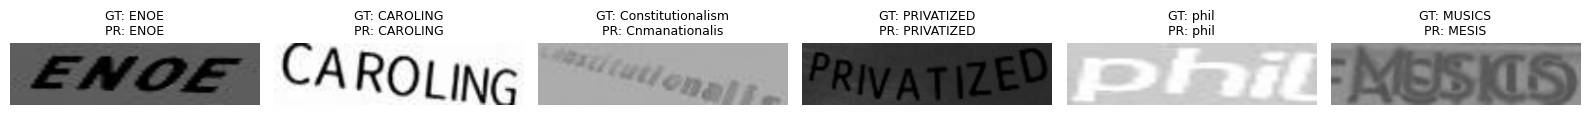


Predictions vs Ground Truth:
[0] PRED: 'ENOE' | GT: 'ENOE'
[1] PRED: 'CAROLING' | GT: 'CAROLING'
[2] PRED: 'Cnmanationalis' | GT: 'Constitutionalism'
[3] PRED: 'PRIVATIZED' | GT: 'PRIVATIZED'
[4] PRED: 'phil' | GT: 'phil'
[5] PRED: 'MESIS' | GT: 'MUSICS'


In [37]:
# --- Final evaluation and visualization ---
# Load best checkpoint
ckpt_path = f"best_{config['arch']}.pth"
ckpt = torch.load(ckpt_path, map_location=device)
vocab = list(ckpt["vocab"])
blank_idx = ckpt["blank_idx"]
model = build_model(ckpt["arch"]).to(device)

# --- Fix ViT positional embedding shape if needed ---
if ckpt["arch"] == "vit_tiny":
    core = model.backbone.core  # timm ViT
    n_ckpt = ckpt["state_dict"]["backbone.core.pos_embed"].shape[1]
    if core.pos_embed.shape[1] != n_ckpt:
        gh = int(((n_ckpt - 1) ** 0.5))
        gw = (n_ckpt - 1) // gh
        resized = resize_pos_embed(core.pos_embed, gh, gw)
        core.pos_embed = torch.nn.Parameter(resized)
model.load_state_dict(ckpt["state_dict"], strict=True)

# Evaluate on test set
print("\n=== Final Test Set Evaluation ===")
counter = ValCounter()
model.eval()

with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):
    test_loss = 0.0
    for imgs, labels, lens in test_loader:
        imgs, labels, lens = imgs.to(device), labels.to(device), lens.to(device)
        logits = model(imgs)
        T = logits.size(0)
        tgt = torch.cat([labels[i, :l] for i, l in enumerate(lens) if l > 0])
        tgt_len = lens[lens > 0]
        mask = lens > 0
        if mask.sum() == 0: continue

        # Compute loss
        loss = criterion(
            logits[:, mask, :].log_softmax(2),
            tgt,
            torch.full((mask.sum(),), T, dtype=torch.long, device=device),
            tgt_len,
        )
        test_loss += loss.item()

        # Decode predictions
        preds = ctc_greedy_decoder(logits, vocab, blank_idx)
        idxs = torch.nonzero(mask, as_tuple=False)[:, 0].tolist()
        gts = [decode_label(labels[i, :lens[i]].cpu().tolist(), vocab, blank_idx) for i in idxs]

        # Update metrics
        counter.update([preds[i] for i in idxs], gts)

test_loss /= len(test_loader)
test_metrics = counter.compute()

print(f"Test Loss: {test_loss:.4f}")
print(f"CER: {test_metrics['CER']:.2%}")
print(f"Word Accuracy @0: {test_metrics['Word Accuracy @ 0']:.2%}")
print(f"Word Accuracy @1: {test_metrics['Word Accuracy @ 1']:.2%}")
print(f"Word Accuracy @2: {test_metrics['Word Accuracy @ 2']:.2%}")

# Visualize predictions on a random validation batch
visualize_predictions(model, val_dataset, vocab, blank_idx, n=6)

In [38]:
# --- Diagnostic cell: print predictions, ground truths, and logits for a batch ---
model.eval()
batch = next(iter(val_loader))
imgs, labels, lens = batch
imgs = imgs.to(device)
with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):
    logits = model(imgs).log_softmax(2)  # (T,B,C)
preds = ctc_greedy_decoder(logits, vocab, blank_idx)
gts = [decode_label(labels[i, :lens[i]].cpu().tolist(), vocab, blank_idx) for i in range(len(labels))]

print("\nSample predictions vs ground truth:")
for i, (p, g) in enumerate(zip(preds, gts)):
    print(f"[{i}] PRED: '{p}' | GT: '{g}'")
    print(f"Logits (min, max): {logits[:,i,:].min().item():.2f}, {logits[:,i,:].max().item():.2f}")
    print('-'*60)


Sample predictions vs ground truth:
[0] PRED: 'Dellusioning' | GT: 'Disillusioning'
Logits (min, max): -25.24, -0.00
------------------------------------------------------------
[1] PRED: 'Humiating' | GT: 'Humiliating'
Logits (min, max): -25.87, -0.00
------------------------------------------------------------
[2] PRED: 'IDOLIZES' | GT: 'IDOLIZES'
Logits (min, max): -29.38, -0.00
------------------------------------------------------------
[3] PRED: 'Tagus' | GT: 'Tagus'
Logits (min, max): -30.99, -0.00
------------------------------------------------------------
[4] PRED: 'Keroxing' | GT: 'Xeroxing'
Logits (min, max): -28.35, -0.00
------------------------------------------------------------
[5] PRED: 'bagatelle' | GT: 'bagatelle'
Logits (min, max): -32.78, -0.00
------------------------------------------------------------
[6] PRED: 'cutout' | GT: 'cutout'
Logits (min, max): -32.16, -0.00
------------------------------------------------------------
[7] PRED: 'CAGILY' | GT: 'CAGILY'

/tmp/ipython-input-38-4253535194.py:6: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=use_amp):
